In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from math import pi
import cv2
import time

# Question 1

<p>Degradation function: </p>
$$ H(u, v) = \frac{T}{\pi (ua + vb)} \sin[ \pi (ua + vb) ]e^{-j \pi (ua + vb)} $$

In [2]:
def rgb2gray(rgb):
    """Convert an image to grayscale using standard ratios for r,g,b"""
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [3]:
img = rgb2gray(np.array(cv2.imread("DIP.png")))

In [4]:
img = np.pad(img, pad_width=1)

In [5]:
F = np.fft.fftshift(np.fft.fft2(img)) #shift zero-frequency component to the mean 

In [6]:
a, b, T = 0.05, 0.02, 1

In [7]:
def gauss_noise(data, v, u=0):
    """Adds in Gaussian noise to an image (data) based on value of mu and sigma"""
    x = np.abs(data)*255/np.abs(data).max()
    noisy_data = x + np.random.normal(u, v**0.5, data.shape)
    blurred_image = noisy_data
    #print(np.sum(x != np.array(blurred_image)))
    return np.array(blurred_image)

In [8]:
def degradation(a=a, b=b, T=1, fft_img=F):
    """
    Returns the output of a sample degradation function of motion blur in the frequency domain
    @Param:
    1. a - linear motion rate in the horizontal direction (spatial domain)
    2. b - linear motion rate in the vertical direction   (spatial domain)
    3. u - mean
    4. T - Motion blur parameter (time/spatial integration)
    5. fft_img - FFT centered image
    """
    height, width = fft_img.shape
    return [[T if (var := pi * (u * a + v * b)) == 0 else (T * np.sin(var)/var) * np.exp(-1j * var) for v in range(width)] for u in range(height)]

In [9]:
H = degradation()

In [10]:
output_centered_fft = F*H
G = np.fft.ifft2(np.fft.ifftshift(output_centered_fft))
G_noisy = gauss_noise(np.abs(G), v  = 650) #noise level set to 'lightly corrupted'

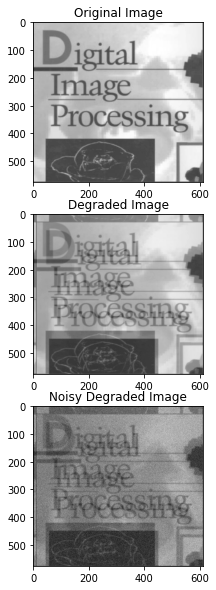

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
ax1.imshow(img, "gray"), ax1.set_title("Original Image")
ax2.imshow(np.abs(G), "gray"), ax2.set_title("Degraded Image")
ax3.imshow(np.abs(G_noisy), "gray"), ax3.set_title("Noisy Degraded Image")
plt.show()

# Question 2

<p>Pseudo-Inverse Filter:
$$ \hat{F}(u,v) = G(u,v) H_{inv}(u,v)$$
    
$$\begin{equation*}
H_{inv}(u,v) = \left\{
        \begin{array}{ll}
            \frac{1}{H(u,v)} \qquad |H(u,v)| > \delta\\
            \quad 0 \qquad \hspace{0.7em} |H(u,v)| \leq \delta
        \end{array}
    \right.
\end{equation*} $$

In [12]:
G_1 = gauss_noise(np.abs(G), v = 650)    # noise level set to 'heavily corrupted'
G_2 = gauss_noise(np.abs(G), v = 65)     # noise level set to 'moderatley corrupted'
G_3 = gauss_noise(np.abs(G), v = 0.0065) # noise level set to 'lightly corrupted'

In [13]:
FFt_G_1 = np.fft.fftshift(np.fft.fft2(G_1))
FFt_G_2 = np.fft.fftshift(np.fft.fft2(G_2))
FFt_G_3 = np.fft.fftshift(np.fft.fft2(G_3))

In [14]:
delta = 0.00005

In [15]:
def inverse_filter(old_filter = np.array(H),delta = delta):
    """
    Computes a pseudo-inverse filter based on the original degredation function
    @Param:
    1. old_filter - FFT centered image
    2. delta - Threshold parameter
    """
    height, width = old_filter.shape
    return [[1/old_filter[u][v] if abs(old_filter[u][v]) > delta else 0 for v in range(width)] for u in range(height)]

In [16]:
H_Inv = inverse_filter()

In [17]:
FHat_1 = np.fft.ifft2(np.fft.ifftshift(FFt_G_1 * H_Inv))
FHat_2 = np.fft.ifft2(np.fft.ifftshift(FFt_G_2 * H_Inv))
FHat_3 = np.fft.ifft2(np.fft.ifftshift(FFt_G_3 * H_Inv))

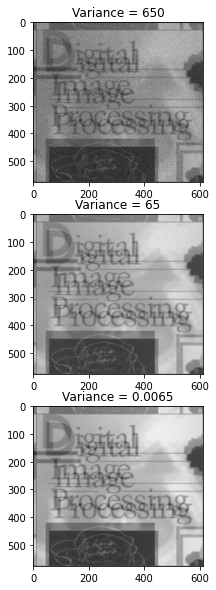

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
ax1.imshow(np.abs(G_1), "gray"), ax1.set_title("Variance = 650")
ax2.imshow(np.abs(G_2), "gray"), ax2.set_title("Variance = 65")
ax3.imshow(np.abs(G_3), "gray"), ax3.set_title("Variance = 0.0065")
plt.show()